#  Building a Text/Topic Classifier with Transfer Learning

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

## Preparing the Data

Download the dataset from here: http://qwone.com/~jason/20Newsgroups/

The data is organized into 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (ie. `comp.sys.ibm.pc.hardware` / `comp.sys.mac.hardware`), while others are highly unrelated (ie. `misc.forsale` / `soc.religion.christian`). Here is a list of the 20 newsgroups, partitioned (more or less) according to subject matter:

	comp.graphics
	comp.os.ms-windows.misc
	comp.sys.ibm.pc.hardware
	comp.sys.mac.hardware
	comp.windows.x
	rec.autos
	rec.motorcycles
	rec.sport.baseball
	rec.sport.hockey
	sci.crypt
	sci.electronics
	sci.med
	sci.space
	misc.forsale
	talk.politics.misc
	talk.politics.guns
	talk.politics.mideast
	talk.religion.misc
	alt.atheism
    soc.religion.christian
    
We use the "bydate" version, sorted by date into training (60%) and test (40%) sets. It's more realistic because the train and test sets are separated in time. It also has been cleaned, it does not include cross-posts and duplicates, and does not include newsgroup-identifying headers (Xref, Newsgroups, Path, Followup-To, Date). In total there are **18846 documents**.

In [3]:
DATA_PATH = Path('../datasets/20news')
DATA_PATH.mkdir(exist_ok=True)

### Data Pre-Processing

*These steps must be performed only once -- specific to the dataset we're using*.

We need to pre-process the dataset first:
1. Rename all files without extension to `.txt`, so they can be "seen" by fastai library helpers.

In [ ]:
import codecs

In [ ]:
for path, subdirs, files in os.walk(DATA_PATH):
    for name in files:
        fullpath = pathlib.PurePath(path, name)
        os.rename(fullpath, str(fullpath) + '.txt')

2. Convert ANSI files to UTF-8 encoding, to avoid errors while loading them.

In [ ]:
for path, subdirs, files in os.walk(DATA_PATH):
    for name in files:
        fullpath = pathlib.PurePath(path, name)
        try:
            #read input file
            with codecs.open(fullpath, 'r', encoding = 'utf8') as file:
                lines = file.read()
        except:
            with codecs.open(fullpath, 'r', encoding = 'ansi') as file:
                lines = file.read()
            #write output file
            with codecs.open(fullpath, 'w', encoding = 'utf8') as file:
                file.write(lines)  

We can now load our data:

In [ ]:
data = TextClasDataBunch.load(DATA_PATH)

In [ ]:
data.show_batch()

Being the line before a bit long, in the future we want to load quickly the final transformed results. So, we can save the work so far by using the following cell:

In [ ]:
data.save('tmp')

and loading back with this one:

In [ ]:
data = TextClasDataBunch.load(DATA_PATH, 'tmp', bs=bs)

In [ ]:
doc(TextClasDataBunch)

## Language Model Fine-Tuning

We are **not** going to train a model that classifies the documents from scratch.

We'll use a model **pretrained** on a bigger dataset (a cleaned subset of Wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess the next word, its input being the previous ones. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, we need to **fine tune** the pretrained model to our particular dataset. Because the English of the documents in the newsgroup isn't the same as the English of Wikipedia, we'll need to adjust the parameters of our model. In addition, there might be some words extremely common in that dataset that were barely present in Wikipedia, and therefore might no be part of the vocabulary the model was trained on.

In [4]:
bs = 32

Let's create our data object with the Data Block API:

In [5]:
data_lm = (TextList.from_folder(DATA_PATH)
            .filter_by_folder(include=['20news-bydate-train', '20news-bydate-test']) 
            .random_split_by_pct(0.1) 
            .label_for_lm()
            .databunch(bs=bs))
data_lm.save('tmp_lm')

From now on, if we want to load quickly the final results, we can use the following cell:

In [ ]:
data_lm = TextLMDataBunch.load(DATA_PATH, 'tmp_lm', bs=bs)

We use a special kind of `TextDataBunch` for the language model, that **ignores the labels**, shuffles the texts at each epoch before concatenating them all together, and sends batches that **read that text in order with inferred targets that are the next word in the sentence**.

In [ ]:
doc(TextLMDataBunch)

In [ ]:
data_lm.show_batch()

In [ ]:
doc(Learner)

We can then put this in a Learner object very easily, with a model loaded with pretrained weights.

In [6]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)

 Pre-trained models will be downloaded the first time you'll execute the previous line, and stored by default in `~/.fastai/models/` (or elsewhere if you changed the config file).

In [7]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


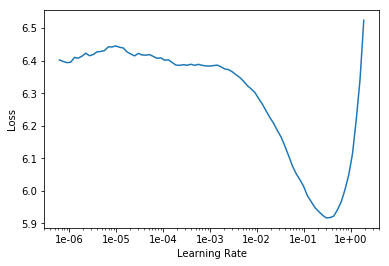

In [8]:
learn.recorder.plot(skip_end=8)

In [9]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.974687,3.748984,0.344966


In [10]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [11]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(15, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.576311,3.525707,0.373544
2,3.225300,3.383976,0.397529
3,3.176068,3.281241,0.416279
4,3.035239,3.200302,0.430831
5,2.908198,3.132305,0.442265
6,2.926290,3.071579,0.452932
7,2.680589,3.020365,0.461733
8,2.666873,2.981960,0.467910
9,2.619888,2.950953,0.474830


In [ ]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [ ]:
learn.load('fine_tuned');

In [ ]:
TEXT = "This is a great match"
N_WORDS = 20
N_SENTENCES = 2

In [ ]:
print("\n\n".join(learn.predict(TEXT, N_WORDS, temperature=0.8, min_p=0.002) for _ in range(N_SENTENCES)))

We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a **new** DataBunch that only grabs the labelled data and keeps those labels. We need to perform the pre-processing to build our newsgroup databunch in such a way that *the vocabulary used to fine-tune the language model is the same*.

So, first, load the fine-tuned language model dataset:

In [ ]:
bs = 12

In [ ]:
data_lm = TextLMDataBunch.load(DATA_PATH, bs=bs, cache_name='tmp_lm')

and use its vocabulary to prepare the classification dataset:

In [ ]:
classes = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
           'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
           'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space',
           'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc',
           'talk.religion.misc']

In [ ]:
data_clas = TextClasDataBunch.from_folder(DATA_PATH, train='20news-bydate-train', valid='20news-bydate-test', classes=classes, vocab=data_lm.vocab)

By executing this line, a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A TextDataBunch does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [ ]:
data_clas.save('tmp_clas')

Next time we launch this notebook, we can skip the cell above that took a bit of time and load the final results like this:

In [ ]:
data_clas = TextClasDataBunch.load(DATA_PATH, 'tmp_clas', bs=bs)

In [ ]:
data_clas.show_batch( )

Let's verify that language model vocabulary is the same as the classification vocabulary:

In [ ]:
len(data_lm.vocab.itos)

In [ ]:
len(data_clas.vocab.itos)

In [ ]:
data_lm.vocab.itos[:30]

In [ ]:
data_clas.vocab.itos[:30]

We can then create a model to classify those documents and load the encoder we saved before.

In [ ]:
doc(text_classifier_learner)

In [ ]:
drop_mult = 0.5

In [ ]:
learn = text_classifier_learner(data_clas, drop_mult=drop_mult)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [ ]:
doc(fit_one_cycle)

In [ ]:
gc.collect();

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))

In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [ ]:
learn.save('third')

In [ ]:
learn.load('third');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [ ]:
learn.save('final')

### Test the final classifier

In [ ]:
learn.load('final')

In [ ]:
learn.show_results()

Let's try with custom text, I got the following examples from web articles:

Computer Graphics

In [ ]:
text = "GeForce RTX graphics cards are the fastest in the world, giving PC gamers the very best framerates and experiences in each and every game. Now, RTX is coming to laptops, starting with over 40 new GeForce RTX laptops, in 100-plus configurations, from partners around the world. And like desktop GeForce RTX graphics cards, RTX laptops have the hardware required for real-time ray tracing and AI-enhanced graphics, enabling you to experience immersive, lifelike visual effects anywhere, anytime."
learn.predict(text)

Baseball

In [ ]:
text = "The Brewers had no such qualms. They recognized that Grandal perennially ranked among the best catchers in baseball at framing pitches for strikes. They also saw a hitter who made up for often low batting averages with a strong batting eye and solid power numbers. In fact, while J.T. Realmuto was the clear leader among catchers last season, Grandal checked in at No. 2 by Wins Above Replacement."
learn.predict(text)

NHL (Hockey)

In [ ]:
text = "Mark Giordano had two goals and an assist in his 800th career game and the Calgary Flames defeated the Arizona Coyotes 7-1 Sunday night. Giordano, the Flames' captain, has 47 points (nine goals, 38 assists) in 45 games this season, second among NHL defensemen and five points behind San Jose's Brent Burns. Matthew Tkachuk scored two goals, and Sean Monahan, Johnny Gaudreau and Sam Bennett also scored for Calgary, which has won five straight and improved to 8-1-1 in its last 10. The Flames lead the Pacific Division by three points over the Sharks. Gaudreau also had an assist, extending his point streak to eight games (eight goals, 10 assists). With 69 points, he ranks second in the league in scoring, six points back of Tampa Bay's Nikita Kucherov."
learn.predict(text)

In [ ]:
text = "Mike Smith got the start in the nets for Calgary in place of red-hot David Rittich. He made 22 saves and improved to 13-9-1. Adin Hill had 19 saves for the Coyotes and fell to 7-5. Calgary surged in front on two goals 68 seconds apart late in the first period. At 16:51, Giordano got the puck in the corner and fired a shot into the top corner from a sharp angle."
learn.predict(text)

Cars

In [ ]:
text = "Our first impression is that it feels like a fairly mature car; Toyota is billing this car as a premium GT set up for occasional track use. The automaker notes that this is the first global model developed by Toyota Gazoo Racing, which put its stamp on the car throughout the entire development process (and also put a small GR badge on the rear of the car, just below its lightweight composite liftback)."
learn.predict(text)

### Prepare for production

Export for visualization in Netron

In [ ]:
torch.save(learn.model[0], DATA_PATH/'models'/'model_lm_netron.pth')
torch.save(learn.model[1], DATA_PATH/'models'/'model_classifier_netron.pth')

Export for use in a Docker Image. We serialize the final model and its metadata, in order to be easily loaded and used in a containerized production environment. The following parameters should match the one used to train the model.

*In this specific example* most of them are fastai default values, so I got them from fastai library source code.

In [ ]:
drop_mult=0.5
dps = default_dropout['classifier'] * drop_mult
bptt=70
emb_sz=400
nh=1150
nl=3
pad_token=1
qrnn=False
max_len=70*20
lin_ftrs = [50]
ps = [0.1]
vocab_size = len(data_clas.vocab.itos)
n_class = len(data_clas.classes)
layers = [emb_sz*3] + lin_ftrs + [n_class]
ps = [dps[4]] + ps

In [ ]:
torch.save(
    { "model": learn.model.state_dict(), 
      "model_params": {
          "drop_mult": drop_mult,
          "dps": dps,
          "bptt": bptt,
          "emb_sz": emb_sz,
          "nh": nh,
          "nl": nl,
          "pad_token": pad_token,
          "qrnn": qrnn,
          "max_len": max_len,
          "lin_ftrs": lin_ftrs,
          "ps": ps,
          "vocab_size": vocab_size,
          "n_class": n_class,
          "layers": layers,
          "ps": ps},
      "vocab": data_clas.vocab.itos,
      "classes": data_clas.classes
    }, DATA_PATH/'models'/'final_for_prod.pth')

### Scoring script

We need to prepare a script for model evaluation to run in a Docker image. The scoring script, called `score.py`, will used by a web service call to make predictions using the trained model. We first prepare a script to work from the command line, later we'll apply few changes to make it working in Azure Machine Learning Services. 

We must include two required functions into the scoring script:

- The `init()` function, which typically loads the model and its metadata into a global object. This function is run only once when the Docker container is started.
- The `run(input_data)` function uses the model to predict a value based on the input data. Inputs and outputs to the run typically use JSON for serialization and de-serialization, but other formats can be supported.

The following script is derived from Fast.AI text learner internal implementation. When we are in production, we do not usually need to have the whole Fast.AI helpers, DataBunch, Learners, and so on. So, we have to extract the key components provided by Fast.AI and use them to replicate the same processing pipeline performed implicitly by the learner.

In [ ]:
PRODUCTION_PATH = Path('./production')
PRODUCTION_PATH.mkdir(exist_ok=True)

In [ ]:
%%writefile ./production/score_cmd.py
from fastai.text import *
from html.parser import HTMLParser

class HTMLTextExtractor(html.parser.HTMLParser):
    def __init__(self):
        super(HTMLTextExtractor, self).__init__()
        self.result = [ ]

    def handle_data(self, d):
        self.result.append(d)

    def get_text(self):
        return ''.join(self.result)
    
    def error(self, message):
        return

def html_to_text(html):
    s = HTMLTextExtractor()    
    try:
        s.feed(html)
        return s.get_text()
    except:
        return html

def custom_tagstrip(x:str) -> str:
    "Remove all html tags in `x`."
    return html_to_text(x)

def load_model(classifier_filename):
    """Load the classifier and related metadata"""
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    state = torch.load(Path(classifier_filename).open('rb'), map_location=device)
    
    if set(state.keys()) == {'model', 'model_params', 'vocab', 'classes'}:
        model_state = state['model']
        model_params = state['model_params']
        itos = state['vocab']
        classes = state['classes']
    else:
        raise RuntimeError("Invalid model provided.")
            
    # Turn it into a string to int mapping (which is what we need)
    stoi = collections.defaultdict(lambda:0, {str(v):int(k) for k,v in enumerate(itos)})
    
    # Get model reference from parameters (even if they are not used at runtime)
    model = get_rnn_classifier(model_params['bptt'],
                               model_params['max_len'],
                               model_params['n_class'],
                               model_params['vocab_size'], 
                               model_params['emb_sz'],
                               model_params['nh'],
                               model_params['nl'],
                               model_params['pad_token'],
                               model_params['layers'],
                               model_params['ps'],
                               input_p=model_params['dps'][0],
                               weight_p=model_params['dps'][1],
                               embed_p=model_params['dps'][2],
                               hidden_p=model_params['dps'][3],
                               qrnn=model_params['qrnn'])

    # Load the trained classifier
    model.load_state_dict(model_state)
    
    # Put the classifier into evaluation mode
    model.reset()
    model.eval()

    return stoi, classes, model

def predict_text(stoi, model, lang, text):
    """Do the actual prediction on the text using the model and mapping files passed"""

    # Predictions are done on arrays of input.
    # We only have a single input, so turn it into a 1x1 array
    texts = [text]

    # Tokenize using the FastAI wrapper around spaCy
    pre_rules = [custom_tagstrip] + defaults.text_pre_rules
    tokens = Tokenizer(lang=lang, pre_rules=pre_rules, n_cpus=1).process_all(texts)

    # Turn into integers for each word
    encoded = np.array([[stoi[o] for o in p] for p in tokens], dtype=np.int64)
    
    # Turn this array into a tensor
    data = torch.from_numpy(encoded)

    # Do the predictions
    predictions = model(data)
    
    # Get class probability from classifier predictions
    res = F.softmax(predictions[0], -1).detach().cpu().numpy()
    
    return res[0]

def init():
    global stoi
    global classes
    global model
    
    # Retrieve the path to the model file using the model name
    model_path = "../../datasets/20news/models/final_for_prod.pth"
    stoi, classes, model = load_model(model_path)

def run(raw_data):
    deser_obj = raw_data
    lang = deser_obj['lang']
    text = deser_obj['text']
    
    # Make prediction  
    scores = predict_text(stoi, model, lang, text)
    pred_class = np.argmax(scores)
    
    print(f"Class: {classes[pred_class]} ({scores[pred_class]})")
    
    # You can return any data type as long as it is JSON-serializable
    return { "label": classes[pred_class], "label_index": pred_class, "label_score": scores[pred_class], "all_scores": scores }

if __name__ == '__main__':
    init()
    run({"lang": sys.argv[1], "text": sys.argv[2]})